En este notebook vamos a implementar una aplicación web donde el usuario pueda buscar las mejores ciudades para viajar en base una descripción y unas fotografía


#**Primeros pasos y carga de datos**

---
Importamos PANDAS y cargamos nuestro propio dataset


In [1]:
import pandas as pd
dataset = pd.read_csv("Datasets2.csv")

Vamos a renombrar los nombres de las columnas y a previsualizar como es nuestro DataFrame

In [2]:
#Renombramos los nombres de las columnas y visualizamos nuestro dataset
dataset = dataset.rename(columns={'Unnamed: 0': 'City', 'Unnamed: 1' : 'Description', 'Unnamed: 2' : 'Country', 'Unnamed: 3' : 'Continent', 'Unnamed: 4' : 'LAT', 'Unnamed: 5' : 'LON'})
#Pasamos las columnas LAT y LON a números buenos en python (cambiamos las comas ',' por puntos '.')
for row in dataset.itertuples():
  #Sabiendo que cada row es una tupla y que el campo 5 y 6 es la LAT y la LON respectivamente...
  lat = str(row[5])
  lon = str(row[6])
  lat = lat.replace(',','.')
  lon = lon.replace(',','.')

  dataset["LAT"].replace({row[5] : lat}, inplace=True)
  dataset["LON"].replace({row[6] : lon}, inplace=True)

dataset = dataset.drop([0])

dataset

,City,Description,Country,Continent,LAT,LON
1,Paris,Paris is the capital and most populous city o...,France,EU,48.8534100,2.3488000
2,Berlin,"Berlin is a world city of culture, politics, m...",Germany,EU,52.5243700,13.4105300
3,Madrid,The Madrid urban agglomeration has the third-l...,Spain,EU,40.4165000,-3.7025600
4,Istanbul,Istanbul is the largest city in Turkey and the...,Turkey,EU,41.0138400,28.9496600
5,Moscow,As the northernmost and coldest megacity in th...,Russia,RU,55.7522200,37.6155600
...,...,...,...,...,...,...
59,Giza,Is the second-largest city in Egypt after Cair...,Egypt,CAF,29.9870,31.2118
60,Ankara,Is the capital of Turkey. Located in the centr...,Turkey,NaN,39.9300,32.8500
61,Houston,"Is the most populous city in Texas, fourth-mos...",EEUU,USA,29.7863,-95.3889
62,Atlanta,It serves as the cultural and economic center...,EEUU,USA,33.7627,-84.4224


In [3]:
listaPaises = list()

listaPaises = list(dataset["Country"])


#Quitamos los valores duplicados
result = []
for item in listaPaises:
    if item not in result:
        result.append(item)
result

['France',
 'Germany',
 'Spain',
 'Turkey',
 'Russia',
 'Italy',
 'Brazil',
 'Mexico',
 'EEUU',
 'China',
 'Japan',
 'UK',
 'Czech Republic',
 'Belgium',
 'Romania',
 'Austria',
 'Greece',
 'Norway',
 'Egypt',
 'Netherlands',
 'Colombia',
 'Thailand',
 'Peru',
 'Argentina',
 'Angola']

Como podemos ver nuestro DataFrame tiene 4 parámetros: 

1.   ***City*** 🡪 Nombre de la ciudad
2.   ***Description*** 🡪 Breve descripción de la ciudad mencionado sus características principales
3.   ***Country*** 🡪 Pais al que pertenece la ciudad
4.   ***Continent*** 🡪 Continente
5.   ***LAT*** 🡪 Latitud
6.   ***LON*** 🡪 Longitud



# **Procesado del texto**

---
Vamos a realizar un tratado del texto de la descripción de cada ciudad, eliminando articulos, palabras irrelevantes y solo quedándonos con las raices de las palabras importantes.

Añadiremos una nueva columna a nuestro DataFrame llamada _processed_text_description_ para ver el resultado de este procesamiento del campo descripción



In [4]:
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

import nltk
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()

preprocessedText = []

for row in dataset.itertuples():
    
    
    text = word_tokenize(row[2]) ## indice de la columna que contiene el texto
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
    text = " ".join(text)
    
    preprocessedText.append(text)

preprocessedData = dataset
preprocessedData['processed_text_description'] = preprocessedText

preprocessedData

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,City,Description,Country,Continent,LAT,LON,processed_text_description
1,Paris,Paris is the capital and most populous city o...,France,EU,48.8534100,2.3488000,pari capit popul citi franc estim popul resid ...
2,Berlin,"Berlin is a world city of culture, politics, m...",Germany,EU,52.5243700,13.4105300,berlin world citi cultur polit media scienc It...
3,Madrid,The Madrid urban agglomeration has the third-l...,Spain,EU,40.4165000,-3.7025600,the madrid urban agglomer gdp european union i...
4,Istanbul,Istanbul is the largest city in Turkey and the...,Turkey,EU,41.0138400,28.9496600,istanbul largest citi turkey countri econom cu...
5,Moscow,As the northernmost and coldest megacity in th...,Russia,RU,55.7522200,37.6155600,As northernmost coldest megac world histori da...
...,...,...,...,...,...,...,...
59,Giza,Is the second-largest city in Egypt after Cair...,Egypt,CAF,29.9870,31.2118,Is citi egypt cairo citi africa kinshasa lago ...
60,Ankara,Is the capital of Turkey. Located in the centr...,Turkey,NaN,39.9300,32.8500,Is capit turkey locat central part anatolia ci...
61,Houston,"Is the most populous city in Texas, fourth-mos...",EEUU,USA,29.7863,-95.3889,Is popul citi texa popul citi unit state popul...
62,Atlanta,It serves as the cultural and economic center...,EEUU,USA,33.7627,-84.4224,It serv cultur econom center atlanta metropoli...


Vemos como ahora nuestro dataset tiene una columna que es el texto procesado de la descripción. Se han eliminado las stopwords, se seleccionan solo las palabras relevantes y se saca su raiz.

#**Representación del texto como un vector: Bag of Words**

---

Necesitamos representar el texto en un formato válido y la forma más utilziada es con un bag-of-words. En esta representación cada documento se transforma en un vector de tamaño igual al número de palabras representativas (términos) que lo constituyen. Cada elemento del vector indica el número de repeticiones de un término en el documento.

##***TF-IDF***
---
_term Frecuency - inverse document frecuency_. Es una forma de medir estadísticamente la importancia que tiene ciera palabra en un texto. Tiene en cuenta el número de veces que un término aparece en un único documento y el númeor de veces que aparece en todos los documentos de la colección

Podríamos resumir que el TF-IDF es una medida numérica que expresa cuán relevante es una palabra para un documento en una colección.



In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer

bagOfWordsModel = TfidfVectorizer()
bagOfWordsModel.fit(preprocessedData['processed_text_description'])
textsBoW= bagOfWordsModel.transform(preprocessedData['processed_text_description'])
print("Finished")

Finished


In [6]:
print(type(textsBoW))
textsBoW.shape

<class 'scipy.sparse.csr.csr_matrix'>


(63, 2058)

Vemos como nos dice que tenemos 33 filas (las 33 ciudades que hay en nuestro DataFrame) y 1262 columnas (701 palabras diferentes en todas las descripciones de las ciudades)

Vamos a mostrar está matriz (omitiendo los valores a 0).

Podemos ver en la siguiente representación:

*   Número de la ciudad 
*   Número de la palabra
*   Valor TF-IDF

(nºciudad, nºpalabra) valor TF-IDF

In [7]:
#print(textsBoW) 

Podemos ver todas las diferentes palabras que tenemos en nuestra _BagOfWords_

In [8]:
bagOfWordsModel.get_feature_names_out()

array(['10', '100', '1032', ..., 'zoo', 'ángel', 'ōdori'], dtype=object)

# **Cálculo de distancias entre vectores de frecuencias**

---

El objetivo ahora es crear una matriz NxN (Número de ciudades) en donde el valor de la posición _matriz[i,j]_ indique la distancia que existe entre la ciudad _i_ y la ciudad _j_.
Gracias a que ahora los textos están representados mediante vectores de frecuencias (_textsBoW_), se puede emplear para ello medidas de distancias standard entre vectores. En nuestro caso, vamos a emplear la distancia *coseno*

In [9]:
from sklearn.metrics import pairwise_distances

distance_matrix= pairwise_distances(textsBoW,textsBoW ,metric='cosine')

In [10]:
print(distance_matrix.shape)
print(type(distance_matrix))
pd.DataFrame(distance_matrix)

(63, 63)
<class 'numpy.ndarray'>


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0,0.000000,0.974079,0.930827,0.921908,0.891645,0.935388,0.962064,0.977909,0.919714,0.964723,0.870354,0.924287,0.945723,0.894741,0.970327,0.935702,0.947667,0.943880,0.900039,0.948389,0.945335,0.934307,0.949680,0.955827,0.912147,0.960724,0.944313,0.944863,0.953005,0.966857,0.945901,0.919591,0.954963,0.898975,0.893143,0.890929,0.872379,0.901275,0.952360,0.941696,0.895087,0.960919,0.947545,0.894868,0.930109,0.936907,0.935937,0.948435,0.932965,0.949000,0.920108,0.933232,0.941455,0.955064,0.965344,0.961606,0.956512,0.929891,0.964453,0.955816,0.921115,0.961461,0.915960
1,0.974079,0.000000,0.911556,0.961887,0.943571,0.967985,0.975691,0.998349,0.944994,0.997292,0.973663,0.985064,0.976802,0.967976,0.987329,0.963607,0.986459,0.981222,0.971849,0.991304,0.946634,0.967611,0.954053,0.932429,0.967662,0.937070,0.941530,0.910582,0.978879,0.960222,0.928090,0.961625,0.955736,0.916614,0.961042,0.984546,0.995413,0.961268,0.978656,0.965161,0.948219,0.981882,0.984774,0.915792,0.958800,0.972984,0.968969,0.950108,0.980342,0.974071,0.997427,0.929891,0.959759,0.979458,0.981751,0.962693,0.989287,0.965763,0.977125,0.992906,0.952799,0.961741,0.943994
2,0.930827,0.911556,0.000000,0.922449,0.932833,0.927618,0.960449,0.958992,0.927325,0.978659,0.881100,0.959868,0.968417,0.933473,0.994518,0.979699,0.976659,0.965350,0.974125,0.991585,0.869075,0.913617,0.933016,0.878851,0.901097,0.860938,0.872485,0.967557,0.895547,0.943165,0.895899,0.947474,0.932303,0.966399,0.917456,0.956126,0.979792,0.930370,0.969188,0.936115,0.895470,0.976053,0.978875,0.897643,0.944757,0.938904,0.969092,0.952768,0.958318,0.977085,0.975309,0.918625,0.956909,0.981452,0.976575,0.947346,0.985426,0.944141,0.964068,0.977443,0.951956,0.915403,0.917284
3,0.921908,0.961887,0.922449,0.000000,0.856728,0.911516,0.976364,0.990249,0.929102,0.966519,0.953613,0.946317,0.922363,0.868102,0.969054,0.896753,0.960108,0.936094,0.935866,0.957397,0.922242,0.901295,0.925962,0.930937,0.914280,0.925334,0.933373,0.904821,0.981493,0.930858,0.931830,0.952116,0.907765,0.940707,0.937139,0.956755,0.994089,0.946105,0.959099,0.941576,0.905773,0.977601,0.934700,0.910516,0.928456,0.960534,0.959227,0.943219,0.893030,0.977420,0.962217,0.943913,0.919740,0.987958,0.940404,0.963813,0.981377,0.942011,0.961156,0.770821,0.942381,0.897336,0.891292
4,0.891645,0.943571,0.932833,0.856728,0.000000,0.923457,0.976160,0.983837,0.928924,0.939978,0.945987,0.930856,0.926577,0.912630,0.978577,0.946569,0.951303,0.971811,0.949843,0.979598,0.935413,0.898273,0.974980,0.917461,0.938162,0.938701,0.928659,0.913296,0.977569,0.967049,0.940110,0.947740,0.925625,0.954136,0.909297,0.943109,0.978493,0.928273,0.942874,0.933223,0.882647,0.970515,0.957948,0.892109,0.950732,0.954985,0.958802,0.936413,0.930387,0.978976,0.978388,0.958630,0.920158,0.985829,0.962346,0.971475,0.974183,0.946756,0.956255,0.954421,0.948079,0.955208,0.942102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.964453,0.977125,0.964068,0.961156,0.956255,0.944370,0.961164,0.983888,0.958506,0.935422,0.955715,0.977450,0.949731,0.970996,0.985095,0.983786,0.990335,0.959012,0.968717,0.990640,0.943758,0.979167,0.978782,0.980311,0.965336,0.959190,0.967471,0.712566,0.986929,0.983428,0.976597,0.981957,0.963779,0.953872,0.911484,0.932418,0.991278,0.948920,0.967796,0.933090,0.939111,0.974339,0.953804,0.955025,0.971925,0.977366,0.982146,0.968832,0.984082,0.947832,0.978358,0.967574,0.965426,0.980595,0.974765,0.944004,0.956286,0.972355,0.000000,0.944174,0.973141,0.976243,0.959212
59,0.955816,0.992906,0.977443,0.770821,0.954421,0.923526,0.966714,0.972738,0.933719,0.989077,0.915049,0.947209,0.942708,0.938825,0.970022,0.954112,0.

Vamos a crear un gráfico para ver está matriz un poco mejor y ver de un vistazo las cosas importantes

1.   Cuanto más parecidas sean las ciudades, más claro el color
2.   Cuanto más diferentes sean las ciudades, más oscuro el color

Con lo cual, vemos como la diagonal de la matriz es blanca, puesto que se compara la ciudad consigo misma. 



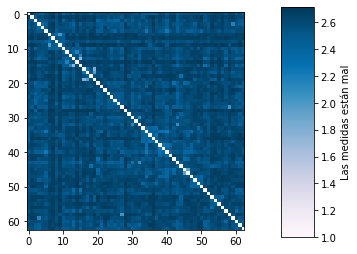

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

XB = np.linspace(0,1,20)
YB = np.linspace(0,1,20)
X,Y = np.meshgrid(XB,YB)
Z = np.exp(distance_matrix)
im = plt.imshow(Z,interpolation='none',cmap='PuBu')

cax = plt.axes([0.85, 0.1, 0.075, 0.8])
plt.colorbar(im, cax=cax,label="Las medidas están mal")
plt.show()

#**Búsqueda de otras ciudades similares en base a la descripción** 

---
Supongamos que el usuario ha seleccionado la ciudad ***Hong Kong*** y vamos a buscar las ciudades más parecidas a esta.

In [12]:
searchCity = "Hong Kong" #Ciudad base para las recomendaciones
indexOfCity = preprocessedData[preprocessedData['City']==searchCity].index.values[0]
indexOfCity

17

In [13]:
#hay que restar uno al índice porque nuestro dataset no empieza en 0 si no en 1
ciudad = preprocessedData.iloc[indexOfCity-1]
ciudad

City                                                                  Hong Kong
Description                   Hong Kong , officially the Hong Kong Special A...
Country                                                                   China
Continent                                                                    AS
LAT                                                                  22.3964280
LON                                                                 114.1094970
processed_text_description    hong kong offici hong kong special administr r...
Name: 17, dtype: object

Calculamos las distancias comparando esa ciudad con las demas
*    0🡪ciudad muy similar
*    1🡪ciudad muy diferente

In [14]:
distance_scores = list(enumerate(distance_matrix[indexOfCity-1]))
distance_scores

[(0, 0.947667034987109),
 (1, 0.9864593018214056),
 (2, 0.9766593118281239),
 (3, 0.9601077051189635),
 (4, 0.9513032428580988),
 (5, 0.9721357108581354),
 (6, 0.9769962465491707),
 (7, 0.9881395086539354),
 (8, 0.9554911532576069),
 (9, 0.9985130262843562),
 (10, 0.9456957832450614),
 (11, 0.9638187186778284),
 (12, 0.9814120464615329),
 (13, 0.9291534313959126),
 (14, 0.9888511278964539),
 (15, 0.967717639750795),
 (16, 0.0),
 (17, 0.8202857948945121),
 (18, 0.9446571839396732),
 (19, 0.5879309869473),
 (20, 0.9749414449265978),
 (21, 0.9628294283858932),
 (22, 0.9624839955173763),
 (23, 0.9776270719337808),
 (24, 0.9690233577384336),
 (25, 0.9664282937757258),
 (26, 0.9849262799858077),
 (27, 0.9372111300770123),
 (28, 0.986813754974884),
 (29, 0.9683429059745279),
 (30, 0.9457657122109538),
 (31, 0.9426749258886973),
 (32, 0.9646151637807513),
 (33, 0.9734713683921247),
 (34, 0.9771189948790237),
 (35, 0.9503056620172602),
 (36, 0.9749131650299394),
 (37, 0.9703573379511877),
 (38,

Vamos a ordenar estas distancias para mostrar la ciudad más similar y solo cogemos las 10 primeras

In [15]:
ordered_scores = sorted(distance_scores, key=lambda x: x[1])
print("Ciudades más parecidas:")
top_scores = ordered_scores[1:11]
top_scores

Ciudades más parecidas:


[(19, 0.5879309869473),
 (17, 0.8202857948945121),
 (13, 0.9291534313959126),
 (56, 0.9367713902279169),
 (27, 0.9372111300770123),
 (54, 0.9404405887680177),
 (31, 0.9426749258886973),
 (38, 0.9445956301127577),
 (18, 0.9446571839396732),
 (10, 0.9456957832450614)]

Con lo cual, las listas de las **menos parecidas** estarán al final. Vamos a cogerlas!

In [16]:
distint_scores = ordered_scores[-10:]
distint_scores

[(12, 0.9814120464615329),
 (26, 0.9849262799858077),
 (46, 0.9859143482795854),
 (1, 0.9864593018214056),
 (28, 0.986813754974884),
 (41, 0.9879699044012097),
 (7, 0.9881395086539354),
 (14, 0.9888511278964539),
 (58, 0.9903349401154029),
 (9, 0.9985130262843562)]

In [17]:
top_indexes = [i[0] for i in top_scores]
top_indexes

[19, 17, 13, 56, 27, 54, 31, 38, 18, 10]

In [18]:
distint_indexes = [i[0] for i in distint_scores]
distint_indexes

[12, 26, 46, 1, 28, 41, 7, 14, 58, 9]

In [19]:
preprocessedData['City'].iloc[top_indexes].tolist()

['Macau',
 'Beijing',
 'New York',
 'Ganzhou',
 'Cairo',
 'Wuhan',
 'Bangkok',
 'Hamburg',
 'Tokyo',
 'Barcelona']

In [20]:
preprocessedData['City'].iloc[distint_indexes]

13       Mexico City
27              Oslo
47        Manchester
2             Berlin
29         Amsterdam
42          Dortmund
8               Vigo
15    Rio de Janeiro
59              Giza
10          Santiago
Name: City, dtype: object

##**Lista definitiva de las ciudades más parecidas**
Dado que las tuplas son inmutables, vamos a pasar nuestra lista de tuplas _top_scores_ a una lista de listas que contenta 3 elementos


*   Índice de la ciudad en el DataFrame
*   Distancia al elemento dado
*   Nombre de la ciudad

Con lo cual nuestra lista quedaría de la siguiente forma: 

[[ indice1 , distancia1 , ciudad1 ],[ indice2 , distancia2 , ciudad2 ],...]



In [21]:
lista = list()
tupla = tuple()
listaSimilares = preprocessedData['City'].iloc[top_indexes].tolist()

for i in top_scores:
  sublista = list()
  for a in i:
    sublista.append(a)
  
  lista.append(sublista)

for i in lista:
  i.append(preprocessedData["City"].iloc[i[0]])


for i in lista:
  print(i)

[19, 0.5879309869473, 'Macau']
[17, 0.8202857948945121, 'Beijing']
[13, 0.9291534313959126, 'New York']
[56, 0.9367713902279169, 'Ganzhou']
[27, 0.9372111300770123, 'Cairo']
[54, 0.9404405887680177, 'Wuhan']
[31, 0.9426749258886973, 'Bangkok']
[38, 0.9445956301127577, 'Hamburg']
[18, 0.9446571839396732, 'Tokyo']
[10, 0.9456957832450614, 'Barcelona']


##**Lista definitiva de las ciudades más diferentes**
Dado que las tuplas son inmutables, vamos a pasar nuestra lista de tuplas _distint_scores_ a una lista de listas que contenta 3 elementos


*   Índice de la ciudad en el DataFrame
*   Distancia al elemento dado
*   Nombre de la ciudad

Con lo cual nuestra lista quedaría de la siguiente forma: 

[[ indice1 , distancia1 , ciudad1 ],[ indice2 , distancia2 , ciudad2 ],...]



In [22]:
listaR = list()
listaDiferentes = preprocessedData['City'].iloc[distint_indexes].tolist()

for i in distint_scores:
  sublista = list()
  for a in i:
    sublista.append(a)
  
  listaR.append(sublista)

for i in listaR:
  i.append(preprocessedData["City"].iloc[i[0]])

for i in listaR:
  print(i)

[12, 0.9814120464615329, 'Mexico City']
[26, 0.9849262799858077, 'Oslo']
[46, 0.9859143482795854, 'Manchester']
[1, 0.9864593018214056, 'Berlin']
[28, 0.986813754974884, 'Amsterdam']
[41, 0.9879699044012097, 'Dortmund']
[7, 0.9881395086539354, 'Vigo']
[14, 0.9888511278964539, 'Rio de Janeiro']
[58, 0.9903349401154029, 'Giza']
[9, 0.9985130262843562, 'Santiago']


#**Creación de nuestra propia fórmula**


---

Vamos a crear nuestra propia fórmula y así poder recomedar mejor las ciudades

Para empezar, si una ciudad está en el mismo pais que una dada, vamos a multiplicarla por 0.92. Vamos a ver  como, si seleccionamos Hong Kong como antes, nos aparerá resultados un poco más similaes trás aplicar nuestra formula

Listado de ciudades sin aplicar la fórmula:

*   Macau
*   Beijing
*   New York
*   Ganzhou
*   Cairo
*   Wuhan
*   Bangkok
*   Hamburg
*   Tokyo
*   Barcelona


Vamos a ver el código para aplicar nuestra fórmula y el listado final para comparar resultados

In [23]:
searchCity = "Hong Kong" #Ciudad base para las recomendaciones
indexOfCity = preprocessedData[preprocessedData['City']==searchCity].index.values[0]
indexOfCity

17

In [24]:
#hay que restar uno al índice porque nuestro dataset no empieza en 0 si no en 1
ciudad = preprocessedData.iloc[indexOfCity-1]
ciudad

City                                                                  Hong Kong
Description                   Hong Kong , officially the Hong Kong Special A...
Country                                                                   China
Continent                                                                    AS
LAT                                                                  22.3964280
LON                                                                 114.1094970
processed_text_description    hong kong offici hong kong special administr r...
Name: 17, dtype: object

In [25]:
distance_scores = list(enumerate(distance_matrix[indexOfCity-1]))

In [26]:
pais = preprocessedData.iloc[indexOfCity-1]["Country"]
pais

'China'

In [27]:
l = list()

for i in distance_scores:
  t = tuple()
  indice = i[0]
  valor = i[1]
  pais_aux = preprocessedData.iloc[i[0]]["Country"]
  if pais == pais_aux:
    valor = valor*0.92
  t = (indice,valor)
  l.append(t)
#l

In [28]:
ordered_scores = sorted(l, key=lambda x: x[1])
print("Ciudades más parecidas:")
top_scores = ordered_scores[1:11]
top_indexes = [i[0] for i in top_scores]
preprocessedData['City'].iloc[top_indexes].tolist()

Ciudades más parecidas:


['Macau',
 'Beijing',
 'Ganzhou',
 'Wuhan',
 'Fuyang',
 'Heze',
 'New York',
 'Cairo',
 'Bangkok',
 'Hamburg']

Vemos como nuestra lista ahora está mucho mejor a la vista en la lista anterior

#**CRUD**

---


Vamos a hacer una simulación de como se podría crear, ver, actualizar o eliminar ciudades en nuestra aplicación


##*Create*
Crear un ciudad. Añadir una nueva ciudad a nuestro DataFrame

In [29]:
city_name = "Cangas"
city_description = "Cangas is a very beautiful place to live on the coast of Galicia with incredible beaches and very nice people"
country = "Spain"
continent = "EU"

preprocessedText = []

text = word_tokenize(city_description) ## le pasamos el user_input
## Remove stop words
stops = set(stopwords.words("english"))
text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
text = " ".join(text)

preprocessedText.append(text)

preprocessedText

user_row = {'City':city_name, 'Description': city_description, 'Country': country, 'Continent':continent, 'processed_text_description':preprocessedText[0]}
preprocessedData2 = preprocessedData.append(user_row,ignore_index=True)

preprocessedData2

,City,Description,Country,Continent,LAT,LON,processed_text_description
0,Paris,Paris is the capital and most populous city o...,France,EU,48.8534100,2.3488000,pari capit popul citi franc estim popul resid ...
1,Berlin,"Berlin is a world city of culture, politics, m...",Germany,EU,52.5243700,13.4105300,berlin world citi cultur polit media scienc It...
2,Madrid,The Madrid urban agglomeration has the third-l...,Spain,EU,40.4165000,-3.7025600,the madrid urban agglomer gdp european union i...
3,Istanbul,Istanbul is the largest city in Turkey and the...,Turkey,EU,41.0138400,28.9496600,istanbul largest citi turkey countri econom cu...
4,Moscow,As the northernmost and coldest megacity in th...,Russia,RU,55.7522200,37.6155600,As northernmost coldest megac world histori da...
...,...,...,...,...,...,...,...
59,Ankara,Is the capital of Turkey. Located in the centr...,Turkey,NaN,39.9300,32.8500,Is capit turkey locat central part anatolia ci...
60,Houston,"Is the most populous city in Texas, fourth-mos...",EEUU,USA,29.7863,-95.3889,Is popul citi texa popul citi unit state popul...
61,Atlanta,It serves as the cultural and economic center...,EEUU,USA,33.7627,-84.4224,It serv cultur econom center atlanta metropoli...
62,Toronto,Is the capital city of the Canadian province ...,EEUU,USA,43.7417,-79.3733,Is capit citi canadian provinc ontario with re...


Una vez tenemos el nuevo DataFrame, hay que calcular de nuevo los TF-IDF

_Calculando los nuevos TF_IDF_

In [30]:
bagOfWordsModel = TfidfVectorizer()
bagOfWordsModel.fit(preprocessedData2['processed_text_description'])
textsBoW= bagOfWordsModel.transform(preprocessedData2['processed_text_description'])
textsBoW.shape

distance_matrix = pairwise_distances(textsBoW,textsBoW ,metric='cosine')
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.000000,0.973901,0.930801,0.921229,0.890813,0.934678,0.961608,0.977708,0.918744,0.964415,0.869469,0.923460,0.944967,0.894008,0.969917,0.934911,0.947231,0.943374,0.899609,0.947813,0.944921,0.933841,0.949402,0.955392,0.911433,0.960251,0.943748,0.944271,0.952776,0.966552,0.945431,0.919277,0.954359,0.898696,0.892493,0.890316,0.872028,0.900579,0.951742,0.941107,0.894408,0.960477,0.947007,0.894441,0.929637,0.936329,0.935409,0.948083,0.932335,0.948515,0.919664,0.932679,0.940711,0.955241,0.964832,0.961283,0.956135,0.929275,0.964112,0.955203,0.920461,0.961019,0.915278,0.981868
1,0.973901,0.000000,0.911250,0.961668,0.943236,0.967778,0.975466,0.998318,0.944559,0.997241,0.973451,0.984858,0.976538,0.967754,0.987226,0.963346,0.986330,0.981065,0.971731,0.991205,0.946397,0.967422,0.953801,0.932076,0.967374,0.936731,0.941147,0.910276,0.978757,0.960076,0.927798,0.961463,0.955478,0.916378,0.960730,0.984426,0.995342,0.961054,0.978396,0.964840,0.947976,0.981730,0.984590,0.915386,0.958552,0.972724,0.968697,0.949859,0.980220,0.973862,0.997378,0.929659,0.959442,0.979326,0.981653,0.962443,0.989133,0.965548,0.976943,0.992811,0.952614,0.961540,0.943804,1.000000
2,0.930801,0.911250,0.000000,0.922173,0.932353,0.927195,0.960149,0.958840,0.926825,0.978557,0.880804,0.959589,0.968103,0.933113,0.994432,0.979473,0.976440,0.965097,0.973993,0.991484,0.868564,0.913233,0.932694,0.878275,0.900536,0.860181,0.871863,0.967255,0.895106,0.942979,0.895435,0.947466,0.931967,0.966145,0.916993,0.955880,0.979674,0.929968,0.968881,0.935707,0.894982,0.975841,0.978638,0.897225,0.944565,0.938594,0.968856,0.952546,0.958034,0.976847,0.975139,0.918378,0.956530,0.981735,0.976379,0.947017,0.985248,0.943820,0.963855,0.977241,0.951664,0.914975,0.916901,0.985436
3,0.921229,0.961668,0.922173,0.000000,0.855927,0.910874,0.976021,0.990103,0.928285,0.966217,0.952959,0.945525,0.921473,0.867318,0.968628,0.895755,0.959807,0.935671,0.935431,0.957016,0.921864,0.900645,0.925519,0.930413,0.913452,0.924836,0.932671,0.904148,0.981440,0.930483,0.931241,0.951617,0.907013,0.940500,0.936742,0.956367,0.993962,0.945429,0.958578,0.941113,0.905394,0.977328,0.934198,0.909598,0.927754,0.960153,0.958783,0.942936,0.892478,0.977078,0.961918,0.943355,0.918874,0.987762,0.939837,0.963564,0.981113,0.941301,0.960854,0.770394,0.941770,0.896647,0.890523,1.000000
4,0.890813,0.943236,0.932353,0.855927,0.000000,0.922671,0.975750,0.983614,0.928058,0.939655,0.945387,0.930020,0.925612,0.911693,0.978252,0.945641,0.950771,0.971508,0.949629,0.979274,0.934860,0.897778,0.974711,0.916797,0.937283,0.938118,0.928080,0.912374,0.977341,0.966775,0.939531,0.947248,0.924835,0.953890,0.908701,0.942550,0.978212,0.927432,0.942147,0.932560,0.881955,0.970222,0.957359,0.891167,0.950117,0.954377,0.958270,0.936107,0.929861,0.978602,0.978095,0.958093,0.919389,0.985665,0.961872,0.971246,0.973843,0.946171,0.955943,0.953758,0.947499,0.954804,0.941776,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.955203,0.992811,0.977241,0.770394,0.953758,0.922849,0.966231,0.972478,0.932900,0.988858,0.914165,0.946510,0.941901,0.938107,0.969668,0.953214,0.954333,0.901331,0.937665,0.967150,0.969678,0.955435,0.987833,0.983265,0.949303,0.944360,0.956667,0.948259,0.997344,0.969091,0.944833,0.938045,0.931025,0.973150,0.955058,0.969622,0.969908,0.911078,0.973640,0.966307,0.968562,0.985004,0.981160,0.957033,0.940814,0.982115,0.969593,0.969511,0.958305,0.974732,0.935410,0.965938,0.947324,0.964063,0.947739,0.980178,0.961303,0.965914,0.943765,0.000000,0.946851,0.923935,0.944099,1.000000
60,0.920461,0.952614,0.951664,0.941770,0.947499,0.951708,0.986233,0.973917,0.941387,0.97

##*Read*
Vamos a ver como buscar un Ciudad y leer su descripción y ver en qué país está y en que continente

In [31]:
searchCity = "Cangas"
preprocessedData2[preprocessedData2['City']==searchCity]
#preprocessedData2[preprocessedData2['City']==searchCity]["City"]
#Vamos a conseguir poner esto en un formato mejor

,City,Description,Country,Continent,LAT,LON,processed_text_description
63,Cangas,Cangas is a very beautiful place to live on th...,Spain,EU,NaN,NaN,canga beauti place live coast galicia incred b...


Vamos a mostrar esto en un mejor formato para mostrarlo en la interfaz. 
Para ello, comenzaremos haciendo una lista con el resultado de la serie que conseguimos

In [32]:
lista = list(preprocessedData2[preprocessedData2['City']==searchCity].iloc[0])
lista

['Cangas',
 'Cangas is a very beautiful place to live on the coast of Galicia with incredible beaches and very nice people',
 'Spain',
 'EU',
 nan,
 nan,
 'canga beauti place live coast galicia incred beach nice peopl']

Una vez tenemos esto, es mucho más fácil acceder a los elementos de nuestra ciudad buscada

In [33]:
print("City: " + lista[0] + "\n"+ 
      "Description: " + lista[1] + "\n" + 
      "Country: " + lista[2] + "\n" + 
      "Continent: " + lista[3])

City: Cangas
Description: Cangas is a very beautiful place to live on the coast of Galicia with incredible beaches and very nice people
Country: Spain
Continent: EU


##*Update*
Vamos a ver como actualizar una ciudad existente en el DataFrame

In [34]:
city = "Cangas"
description = "Cangas is a very beautiful place to live on the coast of Galicia with incredible beaches and very nice people"
country = "GALICIA"
continent = "EU"

Para actualizar una fila de nuestro DataFrame vamos a utilizar el método at[index, column] = value

In [35]:
preprocessedData2[preprocessedData2['City']==searchCity].index
preprocessedData2.at[preprocessedData2[preprocessedData2['City']==searchCity].index,"Country"] = country
preprocessedData2


,City,Description,Country,Continent,LAT,LON,processed_text_description
0,Paris,Paris is the capital and most populous city o...,France,EU,48.8534100,2.3488000,pari capit popul citi franc estim popul resid ...
1,Berlin,"Berlin is a world city of culture, politics, m...",Germany,EU,52.5243700,13.4105300,berlin world citi cultur polit media scienc It...
2,Madrid,The Madrid urban agglomeration has the third-l...,Spain,EU,40.4165000,-3.7025600,the madrid urban agglomer gdp european union i...
3,Istanbul,Istanbul is the largest city in Turkey and the...,Turkey,EU,41.0138400,28.9496600,istanbul largest citi turkey countri econom cu...
4,Moscow,As the northernmost and coldest megacity in th...,Russia,RU,55.7522200,37.6155600,As northernmost coldest megac world histori da...
...,...,...,...,...,...,...,...
59,Ankara,Is the capital of Turkey. Located in the centr...,Turkey,NaN,39.9300,32.8500,Is capit turkey locat central part anatolia ci...
60,Houston,"Is the most populous city in Texas, fourth-mos...",EEUU,USA,29.7863,-95.3889,Is popul citi texa popul citi unit state popul...
61,Atlanta,It serves as the cultural and economic center...,EEUU,USA,33.7627,-84.4224,It serv cultur econom center atlanta metropoli...
62,Toronto,Is the capital city of the Canadian province ...,EEUU,USA,43.7417,-79.3733,Is capit citi canadian provinc ontario with re...


Tenemos que volver a actualizar las distancias por si se ha modificado el campo de descripción!


In [36]:
bagOfWordsModel = TfidfVectorizer()
bagOfWordsModel.fit(preprocessedData2['processed_text_description'])
textsBoW= bagOfWordsModel.transform(preprocessedData2['processed_text_description'])
textsBoW.shape

distance_matrix = pairwise_distances(textsBoW,textsBoW ,metric='cosine')
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63
0,0.000000,0.973901,0.930801,0.921229,0.890813,0.934678,0.961608,0.977708,0.918744,0.964415,0.869469,0.923460,0.944967,0.894008,0.969917,0.934911,0.947231,0.943374,0.899609,0.947813,0.944921,0.933841,0.949402,0.955392,0.911433,0.960251,0.943748,0.944271,0.952776,0.966552,0.945431,0.919277,0.954359,0.898696,0.892493,0.890316,0.872028,0.900579,0.951742,0.941107,0.894408,0.960477,0.947007,0.894441,0.929637,0.936329,0.935409,0.948083,0.932335,0.948515,0.919664,0.932679,0.940711,0.955241,0.964832,0.961283,0.956135,0.929275,0.964112,0.955203,0.920461,0.961019,0.915278,0.981868
1,0.973901,0.000000,0.911250,0.961668,0.943236,0.967778,0.975466,0.998318,0.944559,0.997241,0.973451,0.984858,0.976538,0.967754,0.987226,0.963346,0.986330,0.981065,0.971731,0.991205,0.946397,0.967422,0.953801,0.932076,0.967374,0.936731,0.941147,0.910276,0.978757,0.960076,0.927798,0.961463,0.955478,0.916378,0.960730,0.984426,0.995342,0.961054,0.978396,0.964840,0.947976,0.981730,0.984590,0.915386,0.958552,0.972724,0.968697,0.949859,0.980220,0.973862,0.997378,0.929659,0.959442,0.979326,0.981653,0.962443,0.989133,0.965548,0.976943,0.992811,0.952614,0.961540,0.943804,1.000000
2,0.930801,0.911250,0.000000,0.922173,0.932353,0.927195,0.960149,0.958840,0.926825,0.978557,0.880804,0.959589,0.968103,0.933113,0.994432,0.979473,0.976440,0.965097,0.973993,0.991484,0.868564,0.913233,0.932694,0.878275,0.900536,0.860181,0.871863,0.967255,0.895106,0.942979,0.895435,0.947466,0.931967,0.966145,0.916993,0.955880,0.979674,0.929968,0.968881,0.935707,0.894982,0.975841,0.978638,0.897225,0.944565,0.938594,0.968856,0.952546,0.958034,0.976847,0.975139,0.918378,0.956530,0.981735,0.976379,0.947017,0.985248,0.943820,0.963855,0.977241,0.951664,0.914975,0.916901,0.985436
3,0.921229,0.961668,0.922173,0.000000,0.855927,0.910874,0.976021,0.990103,0.928285,0.966217,0.952959,0.945525,0.921473,0.867318,0.968628,0.895755,0.959807,0.935671,0.935431,0.957016,0.921864,0.900645,0.925519,0.930413,0.913452,0.924836,0.932671,0.904148,0.981440,0.930483,0.931241,0.951617,0.907013,0.940500,0.936742,0.956367,0.993962,0.945429,0.958578,0.941113,0.905394,0.977328,0.934198,0.909598,0.927754,0.960153,0.958783,0.942936,0.892478,0.977078,0.961918,0.943355,0.918874,0.987762,0.939837,0.963564,0.981113,0.941301,0.960854,0.770394,0.941770,0.896647,0.890523,1.000000
4,0.890813,0.943236,0.932353,0.855927,0.000000,0.922671,0.975750,0.983614,0.928058,0.939655,0.945387,0.930020,0.925612,0.911693,0.978252,0.945641,0.950771,0.971508,0.949629,0.979274,0.934860,0.897778,0.974711,0.916797,0.937283,0.938118,0.928080,0.912374,0.977341,0.966775,0.939531,0.947248,0.924835,0.953890,0.908701,0.942550,0.978212,0.927432,0.942147,0.932560,0.881955,0.970222,0.957359,0.891167,0.950117,0.954377,0.958270,0.936107,0.929861,0.978602,0.978095,0.958093,0.919389,0.985665,0.961872,0.971246,0.973843,0.946171,0.955943,0.953758,0.947499,0.954804,0.941776,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,0.955203,0.992811,0.977241,0.770394,0.953758,0.922849,0.966231,0.972478,0.932900,0.988858,0.914165,0.946510,0.941901,0.938107,0.969668,0.953214,0.954333,0.901331,0.937665,0.967150,0.969678,0.955435,0.987833,0.983265,0.949303,0.944360,0.956667,0.948259,0.997344,0.969091,0.944833,0.938045,0.931025,0.973150,0.955058,0.969622,0.969908,0.911078,0.973640,0.966307,0.968562,0.985004,0.981160,0.957033,0.940814,0.982115,0.969593,0.969511,0.958305,0.974732,0.935410,0.965938,0.947324,0.964063,0.947739,0.980178,0.961303,0.965914,0.943765,0.000000,0.946851,0.923935,0.944099,1.000000
60,0.920461,0.952614,0.951664,0.941770,0.947499,0.951708,0.986233,0.973917,0.941387,0.97

##*Delete*
Vamos a ver como eliminar una ciudad existente en nuestro DataFrame

In [37]:
city = "Cangas"

Para eliminar una ciudad en nuestro DataFrame, vamos a usar el método drop()

In [38]:
preprocessedData2 = preprocessedData2.drop(preprocessedData2[preprocessedData2['City']==city].index,axis=0)
preprocessedData2

,City,Description,Country,Continent,LAT,LON,processed_text_description
0,Paris,Paris is the capital and most populous city o...,France,EU,48.8534100,2.3488000,pari capit popul citi franc estim popul resid ...
1,Berlin,"Berlin is a world city of culture, politics, m...",Germany,EU,52.5243700,13.4105300,berlin world citi cultur polit media scienc It...
2,Madrid,The Madrid urban agglomeration has the third-l...,Spain,EU,40.4165000,-3.7025600,the madrid urban agglomer gdp european union i...
3,Istanbul,Istanbul is the largest city in Turkey and the...,Turkey,EU,41.0138400,28.9496600,istanbul largest citi turkey countri econom cu...
4,Moscow,As the northernmost and coldest megacity in th...,Russia,RU,55.7522200,37.6155600,As northernmost coldest megac world histori da...
...,...,...,...,...,...,...,...
58,Giza,Is the second-largest city in Egypt after Cair...,Egypt,CAF,29.9870,31.2118,Is citi egypt cairo citi africa kinshasa lago ...
59,Ankara,Is the capital of Turkey. Located in the centr...,Turkey,NaN,39.9300,32.8500,Is capit turkey locat central part anatolia ci...
60,Houston,"Is the most populous city in Texas, fourth-mos...",EEUU,USA,29.7863,-95.3889,Is popul citi texa popul citi unit state popul...
61,Atlanta,It serves as the cultural and economic center...,EEUU,USA,33.7627,-84.4224,It serv cultur econom center atlanta metropoli...


Podemos ver como nuestra ciudad "Cangas" ya no está en el DataFrame

Tenemos que volver a calcular las distancias!

In [39]:
bagOfWordsModel = TfidfVectorizer()
bagOfWordsModel.fit(preprocessedData2['processed_text_description'])
textsBoW= bagOfWordsModel.transform(preprocessedData2['processed_text_description'])
textsBoW.shape

distance_matrix = pairwise_distances(textsBoW,textsBoW ,metric='cosine')
pd.DataFrame(distance_matrix)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62
0,0.000000,0.974079,0.930827,0.921908,0.891645,0.935388,0.962064,0.977909,0.919714,0.964723,0.870354,0.924287,0.945723,0.894741,0.970327,0.935702,0.947667,0.943880,0.900039,0.948389,0.945335,0.934307,0.949680,0.955827,0.912147,0.960724,0.944313,0.944863,0.953005,0.966857,0.945901,0.919591,0.954963,0.898975,0.893143,0.890929,0.872379,0.901275,0.952360,0.941696,0.895087,0.960919,0.947545,0.894868,0.930109,0.936907,0.935937,0.948435,0.932965,0.949000,0.920108,0.933232,0.941455,0.955064,0.965344,0.961606,0.956512,0.929891,0.964453,0.955816,0.921115,0.961461,0.915960
1,0.974079,0.000000,0.911556,0.961887,0.943571,0.967985,0.975691,0.998349,0.944994,0.997292,0.973663,0.985064,0.976802,0.967976,0.987329,0.963607,0.986459,0.981222,0.971849,0.991304,0.946634,0.967611,0.954053,0.932429,0.967662,0.937070,0.941530,0.910582,0.978879,0.960222,0.928090,0.961625,0.955736,0.916614,0.961042,0.984546,0.995413,0.961268,0.978656,0.965161,0.948219,0.981882,0.984774,0.915792,0.958800,0.972984,0.968969,0.950108,0.980342,0.974071,0.997427,0.929891,0.959759,0.979458,0.981751,0.962693,0.989287,0.965763,0.977125,0.992906,0.952799,0.961741,0.943994
2,0.930827,0.911556,0.000000,0.922449,0.932833,0.927618,0.960449,0.958992,0.927325,0.978659,0.881100,0.959868,0.968417,0.933473,0.994518,0.979699,0.976659,0.965350,0.974125,0.991585,0.869075,0.913617,0.933016,0.878851,0.901097,0.860938,0.872485,0.967557,0.895547,0.943165,0.895899,0.947474,0.932303,0.966399,0.917456,0.956126,0.979792,0.930370,0.969188,0.936115,0.895470,0.976053,0.978875,0.897643,0.944757,0.938904,0.969092,0.952768,0.958318,0.977085,0.975309,0.918625,0.956909,0.981452,0.976575,0.947346,0.985426,0.944141,0.964068,0.977443,0.951956,0.915403,0.917284
3,0.921908,0.961887,0.922449,0.000000,0.856728,0.911516,0.976364,0.990249,0.929102,0.966519,0.953613,0.946317,0.922363,0.868102,0.969054,0.896753,0.960108,0.936094,0.935866,0.957397,0.922242,0.901295,0.925962,0.930937,0.914280,0.925334,0.933373,0.904821,0.981493,0.930858,0.931830,0.952116,0.907765,0.940707,0.937139,0.956755,0.994089,0.946105,0.959099,0.941576,0.905773,0.977601,0.934700,0.910516,0.928456,0.960534,0.959227,0.943219,0.893030,0.977420,0.962217,0.943913,0.919740,0.987958,0.940404,0.963813,0.981377,0.942011,0.961156,0.770821,0.942381,0.897336,0.891292
4,0.891645,0.943571,0.932833,0.856728,0.000000,0.923457,0.976160,0.983837,0.928924,0.939978,0.945987,0.930856,0.926577,0.912630,0.978577,0.946569,0.951303,0.971811,0.949843,0.979598,0.935413,0.898273,0.974980,0.917461,0.938162,0.938701,0.928659,0.913296,0.977569,0.967049,0.940110,0.947740,0.925625,0.954136,0.909297,0.943109,0.978493,0.928273,0.942874,0.933223,0.882647,0.970515,0.957948,0.892109,0.950732,0.954985,0.958802,0.936413,0.930387,0.978976,0.978388,0.958630,0.920158,0.985829,0.962346,0.971475,0.974183,0.946756,0.956255,0.954421,0.948079,0.955208,0.942102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,0.964453,0.977125,0.964068,0.961156,0.956255,0.944370,0.961164,0.983888,0.958506,0.935422,0.955715,0.977450,0.949731,0.970996,0.985095,0.983786,0.990335,0.959012,0.968717,0.990640,0.943758,0.979167,0.978782,0.980311,0.965336,0.959190,0.967471,0.712566,0.986929,0.983428,0.976597,0.981957,0.963779,0.953872,0.911484,0.932418,0.991278,0.948920,0.967796,0.933090,0.939111,0.974339,0.953804,0.955025,0.971925,0.977366,0.982146,0.968832,0.984082,0.947832,0.978358,0.967574,0.965426,0.980595,0.974765,0.944004,0.956286,0.972355,0.000000,0.944174,0.973141,0.976243,0.959212
59,0.955816,0.992906,0.977443,0.770821,0.954421,0.923526,0.966714,0.972738,0.933719,0.989077,0.915049,0.947209,0.942708,0.938825,0.970022,0.954112,0.

#**DATABASE**

---


En nuestra aplicación tendremos que guardar de alguna forma la información de las ciudades, usuarios, contraseñas...
Para ello usaremos una base de datos con un modelo relación gracias a **sqlite3**.

##_Usuarios_
Para empezar, tendremos una tabla llamada _user_ donde guardaremos la informacion relacionada con los usuarios. Esta tabla tendrá los siguientes campos:
*   Username 🡪 String
*   Password 🡪 String 
*   Privileges 🡪 Boolean

Veamos un ejemplo de como sería esta tabla




In [40]:
usersDataFrame = pd.DataFrame({"Username": "marcos", "Password": "marcos", "Privileges":True},index=[0])
usersDataFrame

,Username,Password,Privileges
0,marcos,marcos,True


El siguiente código intenta mostrar como se realizará la gestión de la tabla en nuestra aplicación web

In [41]:
# DB Management
import sqlite3 
conn = sqlite3.connect('data.db')
c = conn.cursor()

def create_usertable():
	c.execute('CREATE TABLE IF NOT EXISTS userstable(username TEXT,password TEXT,privileges TEXT default FALSE, PRIMARY KEY (username))')
	
def add_userdata(username,password):
	if username == "admin":
		c.execute('INSERT INTO userstable(username,password,privileges) VALUES (?,?,?)',(username,password,True))
	else:
		c.execute('INSERT INTO userstable(username,password) VALUES (?,?)',(username,password))
	conn.commit()

def login_user(username,password):
	c.execute('SELECT * FROM userstable WHERE username =? AND password = ?',(username,password))
	data = c.fetchall()
	return data

def view_all_users():
	c.execute('SELECT * FROM userstable')
	data = c.fetchall()
	return data

##_Ciudades_

Las ciudades será lo realmente importante en nuestra aplicación. Tendremos que pasar del DataFrame cargado a una tabla relacional para poder operar con SQL. La tabla de las ciudades tendrá los siguientes campos:


*   Name
*   Description
*   Country
*   Continent
*   Processed_text_description




Lo primero será comvertir nuestro DataFrame llamado _preprocessedData_ a una tabla SQL. Para ello, usaremos el método .to_sql ya implementado en pandas para un DF.

In [42]:
#from sqlalchemy import create_engine
# DB Management
#import sqlite3 
#conn = sqlite3.connect('data.db')
#c = conn.cursor()

#engine = create_engine('sqlite://', echo=False)
#preprocessedData.to_sql('city',con=conn)
#conn.cursor().execute('INSERT INTO city(City,Description,Country,Continent, Processed_text_description) VALUES (?,?,?,?,?)',("algo", "asidaisdia aidjais dis el want to travel arround the world", "Spain", "EU","Null"))
#conn.cursor().execute("SELECT * FROM city").fetchall()

Una vez ya lo hemos conseguido y vemos todo el resultado de cada fila en tuplas con sus respectivos campos, vamos a ver los métodos que vamos a emplear en la aplicación web

##_Comentarios_

Un usuario podrá dejar un comentario sobre una ciudad que ya haya visitado. Para ello, utilizaremos otra tabla en nuestra base de datos. En este caso se llamará _comment_. Esta tabla tendrá los siguientes campos:


*   Username 🡪 String
*   City 🡪 String
*   Content 🡪 String


Vamos a ver un ejemplo de cómo sería esta tabla:



In [43]:
commentsDataFrame = pd.DataFrame({"Username": "marcos","City": "Paris", "Content": "I did not like this city too much because it is very expensive and there are few things to see"},index=[0])
commentsDataFrame

,Username,City,Content
0,marcos,Paris,I did not like this city too much because it i...


Y la gestión en nuestra aplicación se realizará de la siguiente forma:

In [44]:
# DB Management
import sqlite3 
conn = sqlite3.connect('data.db')
c = conn.cursor()

def create_commenttable():
	c.execute('CREATE TABLE IF NOT EXISTS commenttable(username TEXT, city TEXT, content TEXT, PRIMARY KEY (username,city))')
	
def add_commentdata(username, city, content):
	c.execute('INSERT INTO commenttable(username,city,content) VALUES (?,?,?)',(username, city, content))
	conn.commit()

def view_all_comments():
	c.execute('SELECT * FROM commenttable')
	data = c.fetchall()
	return data

def view_all_comments_city(city):
	c.execute('SELECT * FROM commenttable WHERE city LIKE (?)',(city))
	data = c.fetchall()
	return data


#**COMENTARIOS**

---
Nuestro sistema también podrá catalogar si un comentario es positivo, normal o negativo. 
Para ello, usaremos el csv _semeval-2017-train.csv_


In [45]:
trainingData = pd.read_csv('semeval-2017-train.csv', delimiter='	')
trainingData = trainingData.head(15000) #Eliminar la funcion head() si se quiere usar todo el dataset. Para las pruebas usamos únicamente los 1000 primeros tweets
nltk.download('punkt')
nltk.download('stopwords')

ps = PorterStemmer()

preprocessedText = []

for row in trainingData.itertuples():
    
    
    text = word_tokenize(row[2]) ## indice de la columna que contiene el texto
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
    text = " ".join(text)
    
    preprocessedText.append(text)

preprocessedData = trainingData
preprocessedData['processed_text'] = preprocessedText

preprocessedData

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,label,text,processed_text
0,1,One Night like In Vegas I make dat Nigga Famous,one night like In vega I make dat nigga famou
1,1,Walking through Chelsea at this time of day is...,walk chelsea time day rather love love london ...
2,0,"And on the very first play of the night, Aaron...",and first play night aaron rodger int udfa CB ...
3,0,"Drove the bike today, about 40 miles. Felt lik...",drove bike today 40 mile felt like jim carrey ...
4,-1,looking at the temp outside....hpw did it get ...,look temp outsid get hotter sun goe feel like ...
...,...,...,...
14995,-1,@cheringbiebs MY BIRTHDAY ON FEBRUARY. My frie...,cheringbieb MY birthday ON februari My friend ...
14996,-1,Step 1: Put media-loving Petraeus in a job whe...,step 1 put petraeu job ca talk much step 2 abs...
14997,0,@coolzjay I have DECA pictures tomorrow too th...,coolzjay I deca pictur tomorrow time pictur
14998,1,@CraigOyok haha you gotta give me the info tom...,craigoyok haha got ta give info tomorrow lol


Creación de la bolsa de palabras

In [46]:
bagOfWordsModel = TfidfVectorizer()
bagOfWordsModel.fit(preprocessedData['processed_text'])
textsBoW= bagOfWordsModel.transform(preprocessedData['processed_text'])

Vamos a ver cuantas palabras tenemos

In [47]:
textsBoW.shape

(15000, 22678)

Entrenamiento de un algoritmo de clasificación (SVM)

In [48]:
from sklearn import svm
svc = svm.SVC(kernel='linear') #Modelo de clasificación

X_train = textsBoW #Documentos
Y_train = trainingData['label'] #Etiquetas de los documentos 
svc.fit(X_train, Y_train) #Entrenamiento

SVC(kernel='linear')

Vamos a poner nosotros unos comentarios de prueba para ver como los puntua nuestro sistema

In [49]:
testData  = pd.DataFrame({"label": 1, "text": "This city is incredible! There are many beautiful monuments that you have to see. Worth!"},index=[0])
testData  = testData .append({"label": -1, "text": "I did not like this city at all. Very boring"},ignore_index=True)
testData 

,label,text
0,1,This city is incredible! There are many beauti...
1,-1,I did not like this city at all. Very boring


In [50]:
ps = PorterStemmer()

preprocessedText = []

for row in testData.itertuples():
    
    
    text = word_tokenize(row[2]) ## indice de la columna que contiene el texto
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
    text = " ".join(text)
    
    preprocessedText.append(text)

preprocessedDataTest = testData
preprocessedDataTest['processed_text'] = preprocessedText

preprocessedDataTest

,label,text,processed_text
0,1,This city is incredible! There are many beauti...,thi citi incred there mani beauti monument see...
1,-1,I did not like this city at all. Very boring,I like citi veri bore


**Se tiene que emplear la misma representación de bolsa de palabras que se ha usado para entrenar!**


In [51]:
textsBoWTest= bagOfWordsModel.transform(preprocessedDataTest['processed_text'])

##Clasificación de los documentos de test

In [52]:
X_test = textsBoWTest #Documentos

predictions = svc.predict(X_test) #Se almacena en el array predictions las predicciones del clasificador
predictions = list(predictions)
print(predictions)

[1, -1]


##Evaluación de la predicción

In [53]:
from sklearn.metrics import classification_report

Y_test = testData['label'] #Etiquetas reales de los documentos
Y_test
print(classification_report(Y_test, predictions))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00         1
           1       1.00      1.00      1.00         1

    accuracy                           1.00         2
   macro avg       1.00      1.00      1.00         2
weighted avg       1.00      1.00      1.00         2



Podemos ver como acertó los dos! 
Pruebas hechas: 
* 1000 -> 50% [1 1]
* 6000 -> 50% [1 0]
* 15000 -> 100%. [1 -1]

##Caso más real
Vamos a hacer un caso más real ahora donde un usuario introduce solamente un comentario

In [54]:
User_text = "This city is incredible! There are many beautiful monuments that you have to see. Worth!"

ps = PorterStemmer()

preprocessedText = []


text = word_tokenize(User_text) ## indice de la columna que contiene el texto
## Remove stop words
stops = set(stopwords.words("english"))
text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
text = " ".join(text)

preprocessedText.append(text)

#preprocessedDataTest = testData
#preprocessedDataTest['processed_text'] = preprocessedText

print(preprocessedText)

textsBoWTest= bagOfWordsModel.transform(preprocessedText)
X_test = textsBoWTest #Documentos

predictions = svc.predict(X_test) #Se almacena en el array predictions las predicciones del clasificador
print(predictions)

['thi citi incred there mani beauti monument see worth']
[1]


Vemos como tenemos dos listas, una para el texto procesado y la segunda para la valoración que nos dice un 1, con lo cual, es que es un buen comentario.

Con lo cual, esto es justo lo que queremos que haga en nuestro sistema!

#**HOTELES**



---



Vamos a añadir un nuevo dataset a nuestro proyecto para mostrar los mejores hoteles a una ciudad que quiera visitar el usuario


In [55]:
import re
import pandas as pd
df_hoteles = pd.read_csv("hoteles.csv",encoding='unicode_escape')
df_hoteles

,Hotel name,continent_name,city_name,country_name,Price,Rating,reviews count,info.1,info.2,info.3,info.4,info.5,info.6,info.7
0,"Shangri-La Hotel, Beijing",Asia,Beijing,China,156.666667,5.0,7603,Free Wifi,Free parking,Special offer,Visit hotel website,NaN,NaN,NaN
1,InterContinental Beijing Sanlitun,Asia,Beijing,China,NaN,5.0,1743,Free Wifi,Pool,NaN,NaN,Free cancellation,NaN,NaN
2,Holiday Inn Express Beijing Yizhuang,Asia,Beijing,China,68.000000,5.0,548,Free Wifi,Free parking,NaN,NaN,NaN,NaN,NaN
3,"Shangri-La China World Summit Wing, Beijing",Asia,Beijing,China,NaN,5.0,2318,Free Wifi,Pool,Special offer,Visit hotel website,NaN,NaN,NaN
4,Kerry Hotel Beijing,Asia,Beijing,China,NaN,5.0,5756,Free Wifi,Pool,Special offer,Visit hotel website,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59702,The Bright Resort,South Pacific,Bright,Australia,NaN,4.5,30,Free parking,Pool,NaN,NaN,NaN,NaN,NaN
59703,Bogong View Motor Inn,South Pacific,Bright,Australia,NaN,4.0,150,Free Wifi,Free parking,NaN,NaN,NaN,NaN,NaN
59704,Autumn Abode Cottages,South Pacific,Bright,Australia,NaN,4.5,59,Free parking,NaN,NaN,NaN,NaN,NaN,NaN
59705,The Odd Frog,South Pacific,Bright,Australia,NaN,4.0,97,Free parking,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df_hoteles["country_name"] == "China"

0        False
1        False
2        False
3        False
4        False
         ...  
59702    False
59703    False
59704    False
59705    False
59706    False
Name: country_name, Length: 59707, dtype: bool

##Tratamiento del DataFrame de Hoteles
Como en las columnas _city_name_ y _country_name_ tienen espacios añadidos, tenemos que hacer un tratamiento para quitar dichos espacios.
Hacemos esto porque si no, no concuerdan las búsquedas


Para hacer este tratamiento, vamos a utilizar la función _apply_ implementada en la librería **pandas** y también _strip()_ que es un método de String que elimina los espacios al principio y al final

In [57]:
#for row in df_hoteles.itertuples():
df_hoteles["city_name"] = df_hoteles["city_name"].apply(lambda x : str(x).strip())
df_hoteles["country_name"] = df_hoteles["country_name"].apply(lambda x : str(x).strip())

In [58]:
df_hoteles

,Hotel name,continent_name,city_name,country_name,Price,Rating,reviews count,info.1,info.2,info.3,info.4,info.5,info.6,info.7
0,"Shangri-La Hotel, Beijing",Asia,Beijing,China,156.666667,5.0,7603,Free Wifi,Free parking,Special offer,Visit hotel website,NaN,NaN,NaN
1,InterContinental Beijing Sanlitun,Asia,Beijing,China,NaN,5.0,1743,Free Wifi,Pool,NaN,NaN,Free cancellation,NaN,NaN
2,Holiday Inn Express Beijing Yizhuang,Asia,Beijing,China,68.000000,5.0,548,Free Wifi,Free parking,NaN,NaN,NaN,NaN,NaN
3,"Shangri-La China World Summit Wing, Beijing",Asia,Beijing,China,NaN,5.0,2318,Free Wifi,Pool,Special offer,Visit hotel website,NaN,NaN,NaN
4,Kerry Hotel Beijing,Asia,Beijing,China,NaN,5.0,5756,Free Wifi,Pool,Special offer,Visit hotel website,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59702,The Bright Resort,South Pacific,Bright,Australia,NaN,4.5,30,Free parking,Pool,NaN,NaN,NaN,NaN,NaN
59703,Bogong View Motor Inn,South Pacific,Bright,Australia,NaN,4.0,150,Free Wifi,Free parking,NaN,NaN,NaN,NaN,NaN
59704,Autumn Abode Cottages,South Pacific,Bright,Australia,NaN,4.5,59,Free parking,NaN,NaN,NaN,NaN,NaN,NaN
59705,The Odd Frog,South Pacific,Bright,Australia,NaN,4.0,97,Free parking,NaN,NaN,NaN,NaN,NaN,NaN


Como veremos a continuación, ya puede concordar los elementos de búsqueda

In [59]:
df_hoteles["country_name"] == "China"

0         True
1         True
2         True
3         True
4         True
         ...  
59702    False
59703    False
59704    False
59705    False
59706    False
Name: country_name, Length: 59707, dtype: bool

##Ejemplo de uso
Vamos a ver un ejemplo de uso donde un usuario selecciona una ciudad, por ejemplo _"Paris"_, para mostrar información importante de dicha ciudad. 

A mayores de toda la información, se le mostrará los mejores hoteles que están en nuestro datafame _df_hoteles_



In [60]:
user_city = "Paris"
df_hoteles[df_hoteles["city_name"] == "Paris"]

,Hotel name,continent_name,city_name,country_name,Price,Rating,reviews count,info.1,info.2,info.3,info.4,info.5,info.6,info.7
16697,Hotel Malte - Astotel,Europe,Paris,France,274.333333,5.0,1228,Free Wifi,NaN,NaN,NaN,Free cancellation,NaN,NaN
16698,Hotel Ekta,Europe,Paris,France,505.500000,4.5,864,Free Wifi,Room service,NaN,NaN,Free cancellation,Reserve now,pay at stay
16699,Hotel La Manufacture,Europe,Paris,France,471.000000,4.5,2342,Free Wifi,Bar/Lounge,NaN,NaN,NaN,NaN,NaN
16700,Hotel Eiffel Blomet,Europe,Paris,France,185.750000,4.5,962,Free Wifi,Pool,NaN,NaN,NaN,NaN,NaN
16701,Hotel Da Vinci & Spa,Europe,Paris,France,263.250000,5.0,1144,Free Wifi,Pool,Visit hotel website,NaN,Free cancellation,NaN,NaN
16702,Hotel 34B - Astotel,Europe,Paris,France,NaN,5.0,2570,Free Wifi,NaN,NaN,NaN,Free cancellation,NaN,NaN
16703,B Montmartre Hotel,Europe,Paris,France,243.250000,4.5,1534,Free Wifi,Room service,Visit hotel website,NaN,NaN,NaN,NaN
16704,Hotel Mademoiselle,Europe,Paris,France,157.250000,4.5,1779,Free Wifi,Room service,NaN,NaN,NaN,NaN,NaN
16705,Secret de Paris - Hotel & Spa,Europe,Paris,France,200.500000,5.0,1982,Free Wifi,Room service,NaN,NaN,NaN,NaN,NaN
16706,Hotel des Grands Hommes,Europe,Paris,France,184.250000,4.5,2046,Free Wifi,Room service,Visit hotel website,NaN,NaN,NaN,NaN


# **STREAMLIT**

---

Vamos a lanzar Streamlit para mostrar estos resultados en la web. Todo lo mencionado anteriormente se implementa

##Instalación de librerias
Se instala streamlit y pyngrok

In [61]:
!pip install streamlit

!pip install pyngrok

     |████████████████████████████████| 9.2 MB 7.3 MB/s 
     |████████████████████████████████| 4.3 MB 58.9 MB/s 
     |████████████████████████████████| 76 kB 5.6 MB/s 
     |████████████████████████████████| 111 kB 58.0 MB/s 
     |████████████████████████████████| 180 kB 55.5 MB/s 
     |████████████████████████████████| 164 kB 59.5 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 126 kB 61.4 MB/s 
     |████████████████████████████████| 792 kB 51.4 MB/s 
     |████████████████████████████████| 374 kB 58.4 MB/s 
  Created wheel for blinker: filename=blinker-1.4-py3-none-any.whl size=13478 sha256=9c4cebcdfcb9bcf755ccbb166552bf8e2f35ff1b42c62c5fb0dffe95b4c7c39a
  Stored in directory: /root/.cache/pip/wheels/22/f5/18/df711b66eb25b21325c132757d4314db9ac5e8dabeaf196eab
Successfully built blinker
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
      S

     |████████████████████████████████| 745 kB 7.4 MB/s 
  Created wheel for pyngrok: filename=pyngrok-5.1.0-py3-none-any.whl size=19006 sha256=2fe3502adf20309f32d52364238de77bc83ce472e247478e6f7d5ed64eaee9d6
  Stored in directory: /root/.cache/pip/wheels/bf/e6/af/ccf6598ecefecd44104069371795cb9b3afbcd16987f6ccfb3
Successfully built pyngrok


Para ver la documentación sobre la API streamlit : https://docs.streamlit.io/library/api-reference 

##Código de la Web

A continuación se escribe todo el código de nuestra web al fichero TraveLearning.py. 

In [62]:
df_hoteles2 = pd.read_csv("hoteles.csv",encoding='unicode_escape')

In [63]:
%%writefile TraveLearning.py
import streamlit as st
import pandas as pd
from nltk.tokenize import word_tokenize 
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
from sklearn import svm
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from PIL import Image
import numpy as np

#PAGE_CONFIG = {"page_title":"StColab.io","page_icon":":smiley:","layout":"centered"}
#st.beta_set_page_config(**PAGE_CONFIG)

# DB Management
import sqlite3 
conn = sqlite3.connect('data.db')
c = conn.cursor()

def create_usertable():
	c.execute('CREATE TABLE IF NOT EXISTS userstable(username TEXT,password TEXT,privileges TEXT default FALSE, PRIMARY KEY (username))')
	
def add_userdata(username,password):
	if username == "admin":
		c.execute('INSERT INTO userstable(username,password,privileges) VALUES (?,?,?)',(username,password,True))
	else:
		c.execute('INSERT INTO userstable(username,password) VALUES (?,?)',(username,password))
	conn.commit()

def login_user(username,password):
	c.execute('SELECT * FROM userstable WHERE username =? AND password = ?',(username,password))
	data = c.fetchall()
	return data

def view_all_users():
	c.execute('SELECT * FROM userstable')
	data = c.fetchall()
	return data

#---------------------------COMENTARIOS----------------------------#
def create_commenttable():
	c.execute('CREATE TABLE IF NOT EXISTS commenttable(username TEXT, city TEXT, content TEXT, value INT DEFAULT 2, PRIMARY KEY (username,city,content))')
	
def add_commentdata(username, city, content):
	c.execute('INSERT INTO commenttable(username,city,content) VALUES (?,?,?)',(username, city, content))
	conn.commit()

def add_commentdata_value(username, city, content, value):
	c.execute('INSERT INTO commenttable(username,city,content,value) VALUES (?,?,?,?)',(username, city, content,value))
	conn.commit()

def view_all_comments():
	c.execute('SELECT * FROM commenttable')
	data = c.fetchall()
	return data

def view_all_comments_value2():
	c.execute('SELECT * FROM commenttable WHERE value == 2')
	data = c.fetchall()
	return data

def view_all_comments_city(cityOption):
	c.execute('SELECT * FROM commenttable WHERE city==(?)',(cityOption,))
	data = c.fetchall()
	return data

def insert_value(city, content, value):
	c.execute("UPDATE commenttable SET value = ? WHERE city==? AND content == ?", (value,city,content))
	data = c.fetchall()
	return data

def count_total_comments(city):
	c.execute("SELECT COUNT(*) FROM commenttable WHERE city == ?", (city,))
	data = c.fetchall()
	return data

def count_positive_comments(city):
	c.execute("SELECT COUNT(*) FROM commenttable WHERE city == ? AND value==1", (city,))
	data = c.fetchall()
	return data


#c.execute("DROP TABLE commenttable")



#CREACION DEL DATAFRAME DE USUARIOS
usersDataFrame = pd.DataFrame({"Username": "admin", "Password": "admin", "Privileges":True},index=[0])

#Importamos el dataset y hacemos lo de cambiar las columnas a nombres buenos 
dataset = pd.read_csv("Datasets2.csv")
dataset = dataset.rename(columns={'Unnamed: 0': 'City', 'Unnamed: 1' : 'Description', 'Unnamed: 2' : 'Country', 'Unnamed: 3' : 'Continent', 'Unnamed: 4' : 'LAT', 'Unnamed: 5' : 'LON'})
dataset = dataset.drop([0])
#Pasamos las columnas LAT y LON a números buenos en python (cambiamos las comas ',' por puntos '.')
for row in dataset.itertuples():
  #Sabiendo que cada row es una tupla y que el campo 5 y 6 es la LAT y la LON respectivamente...
  lat = str(row[5])
  lon = str(row[6])
  lat = lat.replace(',','.')
  lon = lon.replace(',','.')

  dataset["LAT"].replace({row[5] : lat}, inplace=True)
  dataset["LON"].replace({row[6] : lon}, inplace=True)

#Creamos la matriz de las distancias para luego pasarlo a las vistas -> es el mismo código que está explicado arriba paso a paso
ps = PorterStemmer()
preprocessedText = []
for row in dataset.itertuples():
    text = word_tokenize(row[2]) ## indice de la columna que contiene el texto
    ## Remove stop words
    stops = set(stopwords.words("english"))
    text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
    text = " ".join(text)
    preprocessedText.append(text)
preprocessedData = dataset
preprocessedData['processed_text_description'] = preprocessedText

bagOfWordsModel = TfidfVectorizer()
bagOfWordsModel.fit(preprocessedData['processed_text_description'])
textsBoW= bagOfWordsModel.transform(preprocessedData['processed_text_description'])
distance_matrix = pairwise_distances(textsBoW,textsBoW ,metric='cosine')


#Dataset de comentarios para el análisis de sentimientos!

df_hoteles = pd.read_csv("hoteles.csv",encoding='unicode_escape')

df_hoteles["city_name"] = df_hoteles["city_name"].apply(lambda x : str(x).strip())
df_hoteles["country_name"] = df_hoteles["country_name"].apply(lambda x : str(x).strip())

def main():
	st.markdown("<h1 style='text-align: center; color: #1ec2f3; font-size:80px;'>TraveLearning</h1>", unsafe_allow_html=True)
	listaCiudades = dataset['City'].tolist()

	menu = ["Home","SingUp","Login","Catalogo de ciudades","Recomendar Ciudades","Filtrar Busqueda", "Añadir comentario a una ciudad","Ver comentarios de una ciudad","About","Valoraciones Comentarios"]
	choice = st.sidebar.selectbox('Menu',menu)
 
	if choice == 'Home':
		image = Image.open('Logo.PNG')
		st.image(image)
		st.markdown("<h4 style='text-align: center; color: #b5b7b8;'>Viajar es la oportunidad de que cada día sea diferente, de conocer personas, historias, lugares, la posibilidad de conocerte a ti mismo a través de los otros.</h4>", unsafe_allow_html=True)
		create_commenttable()
		
	if choice == "SingUp":
		st.subheader("Crea una nueva cuenta!")
		new_user = st.text_input("Username")
		new_password = st.text_input("Password", type='password')
	
		if st.button("Singup"):
			create_usertable()
			add_userdata(new_user,new_password)
			st.success("You have successfully create an valid Account")
			st.info("Go to Login Menu to login")


	if choice == 'Login':
		st.subheader("Login Section")
	
		username = st.sidebar.text_input("User Name")
		password = st.sidebar.text_input("Password", type='password')
	
		if st.sidebar.checkbox("Login"):
			create_usertable()
			result = login_user(username,password)
			if result:
				st.success("Logged in as {}".format(username))
			
				task = st.selectbox("Task",["Añadir destino","Ver destino","Editar destino","Eliminar destino", "Ver todos los usuarios"])
					
				if task == "Añadir destino":
					st.caption("Entrando en añadir ciudad")
					st.subheader("Escriba el nombre del destino")
					city_user = st.text_input('Ciudad')
					st.subheader("Escriba la descripción del destino")
					description_user = st.text_area('Descripción')
					st.subheader("Escriba el país del destino")
					country_user = st.text_input('País')
					st.subheader("Escriba el continente del destino")
					continent_user = st.text_input('Continente')
								
					ps = PorterStemmer()

					preprocessedText = []

					text = word_tokenize(description_user) ## le pasamos el user_input
					## Remove stop words
					stops = set(stopwords.words("english"))
					text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
					text = " ".join(text)

					preprocessedText.append(text)

					user_row = {'City':city_user, 'Description': description_user, 'Country': country_user, 'Continent':continent_user, 'processed_text_description':preprocessedText[0]}
					preprocessedData2 = preprocessedData.append(user_row,ignore_index=True)

					preprocessedData2

					bagOfWordsModel = TfidfVectorizer()
					bagOfWordsModel.fit(preprocessedData2['processed_text_description'])
					textsBoW= bagOfWordsModel.transform(preprocessedData2['processed_text_description'])
					textsBoW.shape

					distance_matrix = pairwise_distances(textsBoW,textsBoW ,metric='cosine')
					pd.DataFrame(distance_matrix)

				if task == "Ver destino" :
					option = st.selectbox('Seleccione una ciudad para mostrar los detalles',dataset['City']) 
					preprocessedText = []
					preprocessedData2 = preprocessedData
					preprocessedData2[preprocessedData2['City']==option]
					lista = list(preprocessedData2[preprocessedData2['City']==option].iloc[0])
					print("City: " + lista[0] + "\n"+ 
					"Description: " + lista[1] + "\n" + 
					"Country: " + lista[2] + "\n" + 
					"Continent: " + lista[3])
					
				if task == "Editar destino" :
					option = st.selectbox('Seleccione una ciudad para editarla',dataset['City']) 

					st.caption("Entrando en añadir ciudad")
					st.subheader("Escriba el nombre del destino")
					city_user = st.text_input('Ciudad')
					st.subheader("Escriba la descripción del destino")
					description_user = st.text_area('Descripción')
					st.subheader("Escriba el país del destino")
					country_user = st.text_input('País')
					st.subheader("Escriba el continente del destino")
					continent_user = st.text_input('Continente') 
					ps = PorterStemmer()

					preprocessedText = []

					text = word_tokenize(description_user) ## le pasamos el user_input
					## Remove stop words
					stops = set(stopwords.words("english"))
					text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
					text = " ".join(text)

					preprocessedText.append(text)

					#user_row = {'City':city_user, 'Description': description_user, 'Country': country_user, 'Continent':continent_user, 'processed_text_description':preprocessedText[0]}
					preprocessedData2 = preprocessedData
					preprocessedData2.at[preprocessedData2[preprocessedData2['City']==option].index,"City"] = city_user
					preprocessedData2.at[preprocessedData2[preprocessedData2['City']==option].index,"Description"] = description_user
					preprocessedData2.at[preprocessedData2[preprocessedData2['City']==option].index,"Country"] = country_user
					preprocessedData2.at[preprocessedData2[preprocessedData2['City']==option].index,"Continent"] = continent_user
					preprocessedData2

					bagOfWordsModel = TfidfVectorizer()
					bagOfWordsModel.fit(preprocessedData2['processed_text_description'])
					textsBoW= bagOfWordsModel.transform(preprocessedData2['processed_text_description'])
					textsBoW.shape

					distance_matrix = pairwise_distances(textsBoW,textsBoW ,metric='cosine')
					pd.DataFrame(distance_matrix)
		 
				if task == "Eliminar destino" : 
					option = st.selectbox('Selecciona un destino a eliminar', dataset['City'])
					ps = PorterStemmer()

					preprocessedText = []

					preprocessedData2 = preprocessedData
					preprocessedData2 = preprocessedData2.drop(preprocessedData2[preprocessedData2['City']==option].index,axis=0)
					preprocessedData2

					bagOfWordsModel = TfidfVectorizer()
		 	
					bagOfWordsModel.fit(preprocessedData2['processed_text_description'])
					textsBoW= bagOfWordsModel.transform(preprocessedData2['processed_text_description'])
					textsBoW.shape

					distance_matrix = pairwise_distances(textsBoW,textsBoW ,metric='cosine')
					pd.DataFrame(distance_matrix)
		 
					st.write("Has eliminado a", option,".")

				if task == "Ver todos los usuarios":
					st.caption("Estos son todos los usuarios")
					user_result = view_all_users()
					clean_db = pd.DataFrame(user_result, columns=["Username", "Password","Privileges"])
					st.dataframe(clean_db)
			else:
				st.warning("Incorrect Password")

#########################################################################################################
	if choice == 'Catalogo de ciudades':
		st.header("Bienvenido al cátalogo de ciudades!")
		st.write("Aquí encontrarás todas las ciudades que hay en nuestro sistema y podrás ver información de ellas")
		for row in dataset.itertuples():
			with st.expander(row[1]):
				description = str(dataset[dataset['City'] == row[1]].iloc[0]["Description"])
				country = str(dataset[dataset['City'] == row[1]].iloc[0]["Country"])
				continent = str(dataset[dataset['City'] == row[1]].iloc[0]["Continent"])
				lat = float(dataset[dataset['City'] == row[1]].iloc[0]["LAT"])
				lon = float(dataset[dataset['City'] == row[1]].iloc[0]["LON"])
				total_comments = int(count_total_comments(str(row[1]))[0][0]) #Tenemos que haces esto último de [0][0] porque nos devulve una lista con dentro una tupla
				positive_comments = count_positive_comments(str(row[1]))[0][0]
				
		
				if total_comments == None:
					total_comments=0
					porcentaje=0
				elif total_comments == 0:
					total_comments=0
					porcentaje=0

				else:
					porcentaje = float((positive_comments/total_comments)*100)
				
				if positive_comments == None:
					positive_comments=0
		
				st.write("Description")
				st.caption(description)

				st.write("Country")
				st.caption(country)
		
				st.write("Continent")
				st.caption(continent)
		
				st.write("Geolocation")
				df  = pd.DataFrame({"lat": lat, "lon": lon},index=[0])
				st.map(df)

				st.write("Total Comments")
				st.caption(str(total_comments))
		
				st.write("Positive Comments")
				st.caption(str(positive_comments))
		
				if porcentaje != 0:
					st.write("Good comments percentage")
					st.caption(str(porcentaje) + "%")
		 
				#Hoteles
				st.write("Hotels")
				#Ordenamos el resultado por mejor valor de rating 
				df_h = df_hoteles[df_hoteles["city_name"]==row[1]].sort_values("Rating", ascending=False)
		
				if(len(df_h)!=0):
					st.dataframe(df_h)
				else:
					st.caption("We don't have information about hotels in this city")



		commentsTable = view_all_comments()
		clean_db = pd.DataFrame(commentsTable, columns=["Username", "City","Content", "Value"])
		st.dataframe(clean_db)

##########################################################################################################
	if choice == 'Recomendar Ciudades':
		#Vamos a hacer que el usuario seleccione una ciudad, y se muestre las ciudades más parecidas
		option = st.selectbox('Seleccione una ciudad para mostrar las más similares',dataset['City'])

		#Mostrar las ciudades más parecidas para dicha ciudad = option
		st.write('Has seleccionado:', option)
	
		#Ahora vamos a buscar las ciudades más parecidas para esa opcion
		searchCity = option #Ciudad para las recomendaciones
		indexOfCity = preprocessedData[preprocessedData['City']==searchCity].index.values[0]
		bagOfWordsModel = TfidfVectorizer()
		bagOfWordsModel.fit(preprocessedData['processed_text_description'])
		textsBoW= bagOfWordsModel.transform(preprocessedData['processed_text_description'])
		distance_matrix = pairwise_distances(textsBoW,textsBoW ,metric='cosine')
		distance_scores = list(enumerate(distance_matrix[indexOfCity-1]))
		pais = preprocessedData.iloc[indexOfCity-1]["Country"]

		print("Ciudades más parecidas:")
		l = list()
		for i in distance_scores:
			t = tuple()
			indice = i[0]
			valor = i[1]
			pais_aux = preprocessedData.iloc[i[0]]["Country"]
			if pais == pais_aux:
				valor = valor*0.92
			t = (indice,valor)
			l.append(t)

		ordered_scores = sorted(l, key=lambda x: x[1])
		top_scores = ordered_scores[1:11] #indices de las ciudades más parecidas
		distint_scores = ordered_scores[-10:] #indices de las ciudades más diferentes
		top_indexes = [i[0] for i in top_scores]
		distint_indexes = [i[0] for i in distint_scores]	

		#Contruimos la lista de las ciudades más similares
		lista = list()
		tupla = tuple()
		listaSimilares = preprocessedData['City'].iloc[top_indexes].tolist()

		for i in top_scores:
			sublista = list()
			for a in i:
				sublista.append(a)
			
			lista.append(sublista)

		for i in lista:
			i.append(preprocessedData["City"].iloc[i[0]])
	 
		#Contruimos la lista de las ciudades más diferentes
		listaR = list()
		listaDiferentes = preprocessedData['City'].iloc[distint_indexes].tolist()

		for i in distint_scores:
			sublista = list()
			for a in i:
				sublista.append(a)

			listaR.append(sublista)
		
		for i in listaR:
			i.append(preprocessedData["City"].iloc[i[0]])
	
		
		listaCiudadesParecidas =lista
		listaCiudadesDistintas = listaR
	
		st.header('Lista de las ciudades mas parecidas')
		container = st.container()

#		if st.button('Say hello'):
#			st.write('Why hello there')
#		else:
#			st.write('Goodbye')


		for i in listaCiudadesParecidas: 
			#container.button(i[2] + " -> Distancia: " +str(i[1]))
			with st.expander(i[2]):
				description = str(dataset[dataset['City'] == i[2]].iloc[0]["Description"])
				country = str(dataset[dataset['City'] == i[2]].iloc[0]["Country"])
				continent = str(dataset[dataset['City'] == i[2]].iloc[0]["Continent"])
				lat = float(dataset[dataset['City'] == i[2]].iloc[0]["LAT"])
				lon = float(dataset[dataset['City'] == i[2]].iloc[0]["LON"])
		
				st.write("Description")
				st.caption(description)

				st.write("Country")
				st.caption(country)
		
				st.write("Continent")
				st.caption(continent)
		
				st.write("Geolocalización")
				df  = pd.DataFrame({"lat": lat, "lon": lon},index=[0])
				st.map(df)
	
				st.write("Hotels")
				df_h = df_hoteles[df_hoteles["city_name"]==i[2]].sort_values("Rating", ascending=False)
		
				if(len(df_h)!=0):
					st.dataframe(df_h)
				else:
					st.caption("We don't have information about hotels in this city")

		
				 
		st.header('Lista de las ciudades mas diferentes')
	
		for i in listaCiudadesDistintas: 
			with st.expander(i[2]):
				description = str(dataset[dataset['City'] == i[2]].iloc[0]["Description"])
				country = str(dataset[dataset['City'] == i[2]].iloc[0]["Country"])
				continent = str(dataset[dataset['City'] == i[2]].iloc[0]["Continent"])
				lat = float(dataset[dataset['City'] == i[2]].iloc[0]["LAT"])
				lon = float(dataset[dataset['City'] == i[2]].iloc[0]["LON"])
		
				st.write("Description")
				st.caption(description)

				st.write("Country")
				st.caption(country)
		
				st.write("Continent")
				st.caption(continent)
		
				st.write("Geolocalización")
				df  = pd.DataFrame({"lat": lat, "lon": lon},index=[0])
				st.map(df)
		
				st.write("Hotels")
		
				df_h = df_hoteles[df_hoteles["city_name"]==i[2]].sort_values("Rating", ascending=False)
		
				if(len(df_h)!=0):
					st.dataframe(df_h)
				else:
					st.caption("We don't have information about hotels in this city")

####################################################################################

	if choice == "Filtrar Busqueda":

		listaContinentesDuplicados = list()
		listaContinentesDuplicados = list(dataset["Continent"])
		#Quitamos los valores duplicados
		listaContinentes = list()
		for item in listaContinentesDuplicados:
			if item not in listaContinentes:
				listaContinentes.append(item)

		continent = st.sidebar.selectbox("Continente",listaContinentes)

		listaPaisesDuplicados = list()
		listaPaisesDuplicados = list(dataset[dataset["Continent"] == continent]["Country"])
		#Quitamos los valores duplicados
		listaPaises = list()
		for item in listaPaisesDuplicados:
			if item not in listaPaises:
				listaPaises.append(item)
				
		country = st.sidebar.selectbox("Country",listaPaises)
		cercania = st.sidebar.select_slider(
				'Select your proximity to the city you want to go',
				options=['Muy cerca', 'Cerca', 'Sin más', 'Lejos', 'Muy lejos'])
	
		#Muy cerca -> mismo pais
		#Cerca -> mismo continente
		#Sin Más -> da igual, no pondera especial
		#Lejos -> Otro continente
		#Muy lejos -> Otro continente

		countPaises = list(dataset[dataset["Country"] == country]["City"])
		for i in range(len(countPaises)):
			with st.expander(countPaises[i]):
				description = str(dataset[dataset['City'] == countPaises[i]].iloc[0]["Description"])
				country = str(dataset[dataset['City'] == countPaises[i]].iloc[0]["Country"])
				continent = str(dataset[dataset['City'] == countPaises[i]].iloc[0]["Continent"])
				lat = float(dataset[dataset['City'] == countPaises[i]].iloc[0]["LAT"])
				lon = float(dataset[dataset['City'] == countPaises[i]].iloc[0]["LON"])
		
				total_comments = int(count_total_comments(str(countPaises[i]))[0][0]) #Tenemos que haces esto último de [0][0] porque nos devulve una lista con dentro una tupla
				positive_comments = count_positive_comments(str(countPaises[i]))[0][0]
				
		
				if total_comments == None:
					total_comments=0
					porcentaje=0
				elif total_comments == 0:
					total_comments=0
					porcentaje=0

				else:
					porcentaje = float((positive_comments/total_comments)*100)
				
				if positive_comments == None:
					positive_comments=0
		
				st.write("Description")
				st.caption(description)

				st.write("Country")
				st.caption(country)
		
				st.write("Continent")
				st.caption(continent)
		
				st.write("Geolocalización")
				df  = pd.DataFrame({"lat": lat, "lon": lon},index=[0])
				st.map(df)
		
				st.write("Total Comments")
				st.caption(str(total_comments))
		
				st.write("Positive Comments")
				st.caption(str(positive_comments))
		
				if porcentaje != 0:
					st.write("Good comments percentage")
					st.caption(str(porcentaje) + "%")

				st.write("Hotels")
				df_h = df_hoteles[df_hoteles["city_name"]==countPaises[i]].sort_values("Rating", ascending=False)
		
				if(len(df_h)!=0):
					st.dataframe(df_h)
				else:
					st.caption("We don't have information about hotels in this city")



#######################################################################################

	if choice == "Añadir comentario a una ciudad":
		
		username = st.text_input("Cual es tu nombre?")
		#create_commenttable()

		username = username.strip() #Para quitar los espacios en blanco

		if username == "":
			st.warning("Tienes que poner tu nombre para continuar")
		else:
			addOption = st.radio(
				"What do you want to add, valoration or comment?",
				('Comment', 'Valoration'))
	 
			st.subheader("Which city would you like to add a comment/valoration to")
			cityOption = st.selectbox("Seleccione una ciudad",dataset['City'])
	
			if addOption == "Comment":
				user_input = st.text_area("Añade aquí tu comentario:")

				st.write("Tu comentario para **_", cityOption, "_**es: *", user_input, "*")

				if user_input != "":
					#create_commenttable()
					add_commentdata(username,cityOption,user_input)
					#User_text = "This city is incredible! There are many beautiful monuments that you have to see. Worth!"
					user_input=""

			if addOption == "Valoration":
				st.caption("") #Para añadir más margen, única solución :(
				col1, col2 = st.columns(2)

				st.caption("") #Para añadir más margen, única solución :(
		
				with col1:
					valorationOption = st.select_slider(
							"Did you like the city?", 
							options=["Not really", "More or less", "Very much!"])
				with col2:
					st.caption("")

				if st.button('Guardar'):
					if valorationOption == "Not really":
						valorationOption = -1
					elif valorationOption == "More or less":
						valorationOption = 0
					else:
						valorationOption = 1

					add_commentdata_value(username,cityOption,"",valorationOption)
					st.success("Your comment has been saved")
					

		commentsTable = view_all_comments()
		clean_db = pd.DataFrame(commentsTable, columns=["Username", "City","Content", "Value"])
		st.dataframe(clean_db)

#########################################################################################################
	if choice == "Ver comentarios de una ciudad":

		st.header("De que ciudad quieres ver los comentarios asociados?")
		cityOption = st.selectbox("Seleccione una ciudad",dataset['City'])
	
		commentsTable = view_all_comments_city(cityOption)
		st.write(len(commentsTable))
	
		if(len(commentsTable)==0):
			st.error("No hay comentarios asociadas a dicha ciudad!")
		else:
			clean_db = pd.DataFrame(commentsTable, columns=["Username", "City","Content","Value"])
			st.dataframe(clean_db)


	if choice == "About":
		st.caption("Este proyecto fue diseñado e implementado por: ...")


	if choice == "Valoraciones Comentarios":
		st.caption("Esta página sirve para que el sistema cargue el dataset de comentarios y asigne una valoración a cada uno de si es bueno, regular o malo")
		
		trainingData = pd.read_csv('semeval-2017-train.csv', delimiter='	')
		trainingData = trainingData.head(15000) #Eliminar la funcion head() si se quiere usar todo el dataset. Para las pruebas usamos únicamente los 1000 primeros tweets
		nltk.download('punkt')
		nltk.download('stopwords')

		ps = PorterStemmer()

		preprocessedText = []

		for row in trainingData.itertuples():
					
			text = word_tokenize(row[2]) ## indice de la columna que contiene el texto
			## Remove stop words
			stops = set(stopwords.words("english"))
			text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
			text = " ".join(text)
			
			preprocessedText.append(text)

		preprocessedData2 = trainingData
		preprocessedData2['processed_text'] = preprocessedText

		bagOfWordsModel2 = TfidfVectorizer()
		bagOfWordsModel2.fit(preprocessedData2['processed_text'])
		textsBoW= bagOfWordsModel2.transform(preprocessedData2['processed_text'])

		svc = svm.SVC(kernel='linear') #Modelo de clasificación

		X_train = textsBoW #Documentos
		Y_train = trainingData['label'] #Etiquetas de los documentos 
		svc.fit(X_train, Y_train) #Entrenamiento

		###############
		ps = PorterStemmer()

		preprocessedText = []

		commentsTable = view_all_comments_value2()
		clean_db = pd.DataFrame(commentsTable, columns=["Username", "City","Content", "Value"])
		st.dataframe(clean_db)

		#user_text = "This city is incredible! There are many beautiful monuments that you have to see. Worth!"

		for row in clean_db.itertuples():
					
			text = word_tokenize(row[3]) ## indice de la columna que contiene el texto
			## Remove stop words
			stops = set(stopwords.words("english"))
			text = [ps.stem(w) for w in text if not w in stops and w.isalnum()]
			text = " ".join(text)
			
			preprocessedText.append(text)

		preprocessedData2 = clean_db
		preprocessedData2['processed_text'] = preprocessedText

		#st.write(preprocessedText)

		textsBoWTest= bagOfWordsModel2.transform(preprocessedData2['processed_text'])
		X_test = textsBoWTest #Documentos

		predictions = svc.predict(X_test) #Se almacena en el array predictions las predicciones del clasificador
		predictions = list(predictions)

		contador = 0
	
		for row in clean_db.itertuples():
			city = row[2]
			content = row[3]
			value = int(predictions[contador])
			
			insert_value(city, content, value)
			contador = contador +1

		#add_commentdata("Prueba","Ourense","asdiasdiaiajsdiasdiaisdjiasdijasdijasjasidja")
		commentsTable = view_all_comments()
		clean_db = pd.DataFrame(commentsTable, columns=["Username", "City","Content", "Value"])
		st.dataframe(clean_db)
	


	



if __name__ == '__main__':
	main()
 
def getUserDataFrame():
	return usersDataFrame
 

Writing TraveLearning.py


##Lanzar Aplicación TraveLearning.py
Se ejecuta nuestra aplicación en segundo plano y se crea un NgrokTunnel en el puerto 8501

In [69]:
!streamlit run TraveLearning.py &>/dev/null &

In [65]:
from pyngrok import ngrok

In [70]:
# Setup a tunnel to the streamlit port 8501
ngrok.set_auth_token("22EF8Enh10cKxuEhAZyKrPkOF0y_3NqBbv2dgw5skYRnQzWM")
public_url = ngrok.connect(8501)
public_url

<NgrokTunnel: "http://e574-34-125-97-182.ngrok.io" -> "http://localhost:8501">

##Deterner nuestra aplicación
Dejamos aquí el codigo por si se quisiera cerrar la aplicación

In [67]:
ngrok.kill()

#**Exportación del código**


In [68]:
#!wget -nc https://raw.githubusercontent.com/brpy/colab-pdf/master/colab_pdf.py
#from colab_pdf import colab_pdf
#colab_pdf('ABP.ipynb')